# Random Forest

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante RandomForest

Se utilizarán cuatro preprocessings diferentes:
* Las variables utilizadas en la primera parte del trabajo práctico.
* Todas las variables pero el data frame equilibrado
* Todas las variables sin modificación alguna
* PCA del 90% de la varianza.

In [1]:
# Modelo
from sklearn.ensemble import RandomForestClassifier

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
from preprocessing import preprocessing_base_parte_1
from preprocessing import preprocessing_equilibrado
from preprocessing import preprocessing_significantes
import utils

In [2]:
df = utils.get_data()

### Modelo 1 - Preprocessing parte 1

Este RandomForest será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

Además, de los hiperparámetros rescatamos que entrenaremos un RandomForest que mirará un máximo de features de 2

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=27, stratify=Y)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

#### Búsqueda de la mejor altura

In [4]:
params = { 'max_depth': range(2,18), 'n_estimators': range(50,1500,50), 'criterion': ['gini', 'entropy'] }
model = RandomForestClassifier(n_jobs=-1, random_state=27)
    
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [5]:
gscv.fit(X_train_1, y_train_1)

Fitting 4 folds for each of 928 candidates, totalling 3712 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 63.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 86.1min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 103.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 121.7min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 143.5min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 174.9min
[Parallel(n_jobs=-1)]: Done 3712 out of 3712 

GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=27),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 18),
                         'n_estimators': range(50, 1500, 50)},
             scoring='roc_auc', verbose=5)

In [6]:
gscv.best_estimator_

RandomForestClassifier(max_depth=12, n_estimators=850, n_jobs=-1,
                       random_state=27)

In [7]:
gscv.best_params_

{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 850}

Vemos que la altura óptima que usaremos es de 12, con 850 estimadores.

Por lo que crearemos el primer modelo:

In [6]:
rfc1 = RandomForestClassifier(n_estimators=850,
                               criterion='gini',
                               max_depth=12,
                               n_jobs=-1,
                               random_state=27)

In [7]:
rfc1.fit(X_train_1, y_train_1)

RandomForestClassifier(max_depth=12, n_estimators=850, n_jobs=-1,
                       random_state=27)

In [8]:
print(classification_report(y_test_1,rfc1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8662    0.9560    0.9089      6181
           1     0.7938    0.5342    0.6386      1960

    accuracy                         0.8544      8141
   macro avg     0.8300    0.7451    0.7737      8141
weighted avg     0.8487    0.8544    0.8438      8141



Buenas métricas para el primer modelo, considerando que la cantidad de features está limitada a 4 (es decir, el modelo está previamente sesgado por la selección).

Veamos cómo se comporta la matriz de confusión

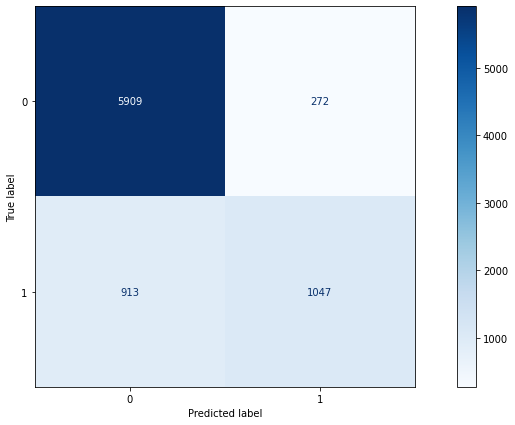

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que, como ya es costumbre la cantidad de falsos negativos es muy alta, pero se mantuvo relativamente baja.

Veamos ahora las métricas de Roc_AUC

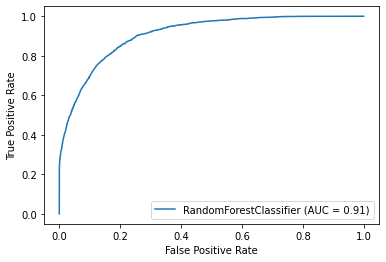

In [10]:
plot_roc_curve(rfc1, X_test_1, y_test_1)

In [11]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_1, rfc1.predict_proba(X_test_1)[:, 1]), 4))

El score de RocAUC es de:  0.9091


Si bien el modelo tuvo una buena performance creemos que se puede llegar más lejos.

### Modelo 2 - Preprocessing equilibrado

Este RandomForest será entrenado con todas las variables disponibles en el data frame, pero antes de entrenarlo se realizará un equilibrio de la variable objetivo (es decir, se desecharán gran parte de los datos de entrenamiento que no sean unos hasta que se alcace un equilibrio y sean 50% unos y 50% ceros)

Esta vez la cantidad de features a mirar en cada split será un poco más alta que el anterior, dejando 4 features en cada split.

Veamos qué sucede.

In [17]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)

X_train_2, X_test_2, y_train_2, y_test_2 = preprocessing_equilibrado(X_train_2, X_test_2, y_train_2, y_test_2)

In [26]:
params = {'max_depth': range(2, 21),
          'n_estimators': range(50,1551,100),
          'criterion': ['gini', 'entropy']}
model = RandomForestClassifier(n_jobs=-1, random_state=27)

gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=4)

In [27]:
gscv.fit(X_train_2, y_train_2)

Fitting 4 folds for each of 608 candidates, totalling 2432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 2432 out of 2432 | elapsed: 69.6min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=27),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 21),
                         'n_estimators': range(50, 1551, 100)},
             scoring='roc_auc', verbose=4)

In [28]:
gscv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=1450,
                       n_jobs=-1, random_state=27)

In [30]:
gscv.best_params_

{'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 1450}

Nos quedamos con el mejor de los modelos, que esta vez tiene una altura de 17 y 800 estimadores.

In [31]:
rfc2 = gscv.best_estimator_

In [32]:
rfc2.fit(X_train_2, y_train_2)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=1450,
                       n_jobs=-1, random_state=27)

In [33]:
print(classification_report(y_test_2,rfc2.predict(X_test_2), digits=4))

              precision    recall  f1-score   support

           0     0.9531    0.7832    0.8599      6182
           1     0.5622    0.8785    0.6857      1959

    accuracy                         0.8062      8141
   macro avg     0.7577    0.8309    0.7728      8141
weighted avg     0.8591    0.8062    0.8180      8141



Vemos que el accuracy nuevamente dio de un 80.6% aproximadamente. Por lo que el modelo es decente, sin embargo, no sólo hay que mirar dicho valor.

El recall de unos es relativamente alto, un 87.9%. Pero el recall de ceros es bajo en relación a otros modelos ejecutados anteriormente.

Los modelos que nacen del data frame equilibrado son peculiares. Suelen tener valores insólitos de Recall de unos.

Veamos la matriz de confusión

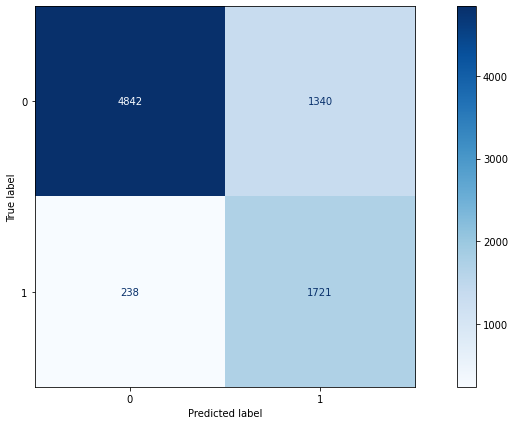

In [34]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Podemos notar que, si bien la cantidad de falsos negativos disminuyó rotúndamente (en comparación a otros modelos) al cantidad de falsos positivos aumentó mucho (Con un valor cercano a los verdaderos positivos, lo cual es preocupante)


Veamos la curva Roc y su puntuación AUC:

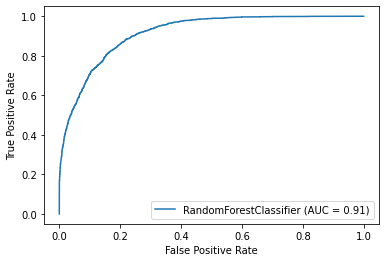

In [35]:
plot_roc_curve(rfc2, X_test_2, y_test_2)

In [24]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_2, rfc2.predict_proba(X_test_2)[:, 1]), 4))

El score de RocAUC es de:  0.9141


El valor de RocAUC es alto, pero en realidad no se trata de un buen modelo para predecir todo, sino más bien para casos particulares como aumentar el recall de unos o disminuir la cantidad de falsos negativos.

## Modelo 3 - Sin preprocesamiento

La idea de este modelo es dejar que RandomForest se entrene sin sesgar las features a utilizar (que pueda utilizar absolutamente todas)

Creemos que esto se justifica ya que RandomForest busca realizar la votación de múltiples árboles relativamente diferentes entre sí, por lo que tiene sentido dejar todas las variables.

Veamos qué sucede!

In [25]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=27, stratify=Y)

In [26]:
params = { 'max_depth': range(2,18), 'n_estimators': range(50,1500,50), 'criterion': ['gini', 'entropy'] }
model = RandomForestClassifier(n_jobs=-1, random_state=27)
    
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [27]:
gscv.fit(X_train_3, y_train_3)

Fitting 4 folds for each of 928 candidates, totalling 3712 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 76.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 180.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 259.5min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 306.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 326.1min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 358.7min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 403.1min
[Parallel(n_jobs=-1)]: Done 3712 out of 37

GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=27),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 18),
                         'n_estimators': range(50, 1500, 50)},
             scoring='roc_auc', verbose=5)

In [28]:
gscv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=950,
                       n_jobs=-1, random_state=27)

In [29]:
gscv.best_params_

{'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 950}

Nos quedamos con el mejor de los modelos, que esta vez tiene una altura de 17 y 950 estimadores.

In [30]:
rfc3 = gscv.best_estimator_

In [31]:
rfc3.fit(X_train_3, y_train_3)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=950,
                       n_jobs=-1, random_state=27)

In [32]:
print(classification_report(y_test_3,rfc3.predict(X_test_3), digits=4))

              precision    recall  f1-score   support

           0     0.8733    0.9489    0.9095      6181
           1     0.7782    0.5658    0.6552      1960

    accuracy                         0.8567      8141
   macro avg     0.8258    0.7573    0.7824      8141
weighted avg     0.8504    0.8567    0.8483      8141



Vemos que el modelo obtuvo un accuracy muy alto, casi de 86%

Además, la precisión para predecir unos y para predecir ceros resulta alta. Sin embargo, como es usual, el recall de unos es bajo (pero relativamente por encima de lo común)

Veamos ahora la matriz de confusión

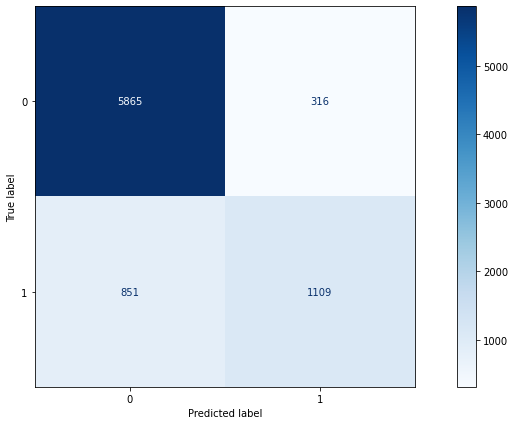

In [33]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc3, X_test_3, y_test_3, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que nuevamente los falsos negativos suben en cantidad. Es relativamente parecida a las otras matrices de confusión vistas a lo largo del trabajo práctico.

Veamos ahora la curva ROC y su puntuación AUC

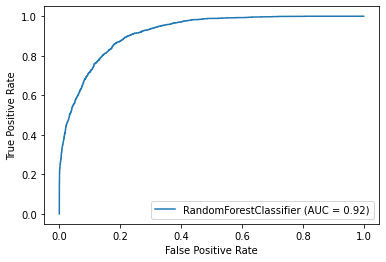

In [34]:
plot_roc_curve(rfc3, X_test_3, y_test_3)

In [35]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_3, rfc3.predict_proba(X_test_3)[:, 1]), 4))

El score de RocAUC es de:  0.9181


### Modelo 4 - Preprocessing Significantes 90%


Queremos ver con este modelo si un RandomForest puede aprender de un data frame preprocesado con PCA del 90% de la varianza y los datos previamente escalados con un StandardScaler.

In [36]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, Y, random_state=112, stratify=Y)

X_train_4, X_test_4 = preprocessing_significantes(X_train_4, X_test_4, 0.9)

/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test[

In [39]:
params = { 'max_depth': range(2,18), 'n_estimators': range(50,1200,50), 'criterion': ['gini', 'entropy'] }
model = RandomForestClassifier(n_jobs=-1, random_state=27)
    
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [40]:
gscv.fit(X_train_4, y_train_4)

Fitting 4 folds for each of 736 candidates, totalling 2944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 83.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 142.7min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 215.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 356.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 502.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 600.0min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 810.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 1118.8min
[Parallel(n_jobs=-1)]: Done 2944 out of 2944 | elapsed: 1414.9min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=27),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 18),
                         'n_estimators': range(50, 1200, 50)},
             scoring='roc_auc', verbose=5)

In [41]:
gscv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=450,
                       n_jobs=-1, random_state=27)

In [42]:
gscv.best_params_

{'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 450}

Nos quedamos con el mejor de los modelos, que esta vez tiene una altura de 11 y 450 estimadores.

In [43]:
rfc4 = gscv.best_estimator_

In [44]:
rfc4.fit(X_train_4, y_train_4)

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=450,
                       n_jobs=-1, random_state=27)

In [45]:
print(classification_report(y_test_4,rfc4.predict(X_test_4), digits=4))

              precision    recall  f1-score   support

           0     0.8662    0.9346    0.8991      6181
           1     0.7255    0.5449    0.6224      1960

    accuracy                         0.8408      8141
   macro avg     0.7959    0.7398    0.7608      8141
weighted avg     0.8324    0.8408    0.8325      8141



El modelo obtuvo un Accuracy de 84%, valor bastante malo para tratarse de un ensamble.

Vemos que el recall de unos es bastante malo, por lo que no esperamos nada particularmente bueno en la matriz de confusión. Realmente no se trata de un buen modelo.

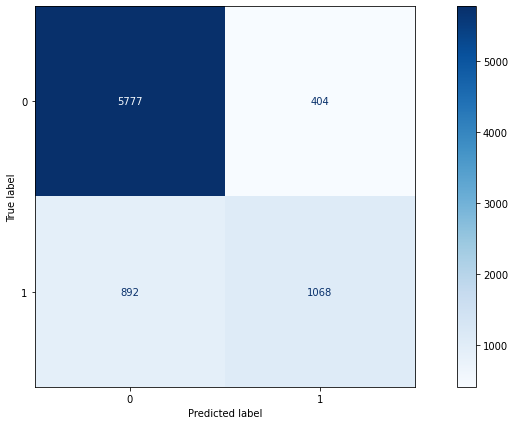

In [46]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc4, X_test_4, y_test_4, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

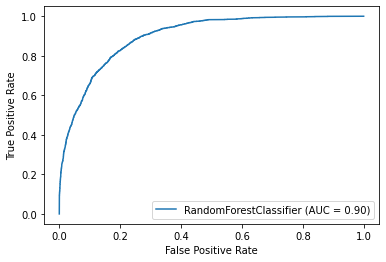

In [47]:
plot_roc_curve(rfc4, X_test_4, y_test_4)

In [48]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_4, rfc4.predict_proba(X_test_4)[:, 1]), 4))

El score de RocAUC es de:  0.8983


# Persistiendo los modelos

In [ ]:
import pickle

In [ ]:
pickle.dump(rfc1, open("Modelos/RandomForest/rfc1.pickle", "wb"))
pickle.dump(rfc2, open("Modelos/RandomForest/rfc2.pickle", "wb"))
pickle.dump(rfc3, open("Modelos/RandomForest/rfc3.pickle", "wb"))
pickle.dump(rfc4, open("Modelos/RandomForest/rfc4.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir el RandomForest obtenido para el preprocessing "sin preprocessing"

In [ ]:
rfc3 = pickle.load(open("Modelos/RandomForest/rfc3.pickle", "rb"))

In [49]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv, drop_first=True)

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X, drop_first=True)
    
    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    return ids, X

In [50]:
ids, X = holdout()

In [51]:
utils.escribir_holdout(rfc3.predict(X), "5 - RandomForest", ids)